# Entrega laboratorio 5

## Integrantes 

- Javier Steven Barrera Toro - 202214779
- Julian Santiago Rolon Toloza - 202215839

In [2]:
from matplotlib import pyplot as plt
from typing import List, Tuple, NewType
import numpy as np
import pandas as pd
import sympy as sp
import copy
import tabulate

np.seterr(divide='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Problema 1

## Formulación del modelo multiobjetivo

### Conjuntos

Definimos 4 conjuntos: 

- $I$: Conjunto de recursos {Alimentos, Medicinas, Equipos, Agua, Mantas}
- $F$: Conjunto de aviones {1,2,3,4}
- $K$: COnjunto de Zonas de destino {A,B,C,D}
- $W$: Conjunto de viajes posibles por avión {1,2}

### Parámetros

#### Parametros para los recursos: 
* $VI_i$: Valor de impacto social por tonelada del recurso $i$.
* $PR_i$: Peso en toneladas por unidad del recurso $i$.
* $VR_i$: Volumen en $m^3$ por unidad del recurso $i$.
* $Disp_i$: Disponibilidad máxima en unidades del recurso $i$.
* $CP_f$: Capacidad máxima de peso (TON) del avión $f$.
* $CV_f$: Capacidad máxima de volumen ($m^3$) del avión $f$.
* $CF_f$: Costo fijo por usar el avión $f$ (miles USD).
* $CVar_f$: Costo variable por km del avión $f$ (miles USD/km).
* $Dist_k$: Distancia en km a la zona $k$.
* $MI_k$: Multiplicador de impacto social para la zona $k$.
* $NM_{ik}$: Necesidad mínima (TON) del recurso $i$ en la zona $k$.
* $PEM$: Peso de una unidad de Equipo Médico (0.3 TON).
* $VEM$: Volumen de una unidad de Equipo Médico (0.5 $m^3$).
* $i_{EM}$: Índice constante correspondiente al recurso "Equipos Médicos".
* $i_{AG}$: Índice constante correspondiente al recurso "Agua Potable".
* $i_{MED}$: Índice constante correspondiente al recurso "Medicinas".
* $f_1$: Índice constante correspondiente al Avión 1.
* $M$: Un número suficientemente grande (para linealización de restricciones).


### Variables de decisión

* $C_{ifkv}$: Cantidad (en toneladas) del recurso $i$ ($i \neq i_{EM}$) transportada por el avión $f$ a la zona $k$ en el viaje $v$. (Continua)
* $U_{fkv}$: Número de unidades de Equipos Médicos ($i = i_{EM}$) transportadas por el avión $f$ a la zona $k$ en el viaje $v$. (Entera)
* $X_{fkv}$: Variable binaria. 1 si el avión $f$ viaja a la zona $k$ en el viaje $v$; 0 c.c.
* $Y_f$: Variable binaria. 1 si el avión $f$ es utilizado; 0 c.c.
* $W_{fv}$: Variable binaria. 1 si el avión $f$ realiza el viaje $v$; 0 c.c.
* $TE_{fv}$: Variable binaria auxiliar. 1 si el avión $f$ transporta Equipos Médicos en el viaje $v$; 0 c.c.
* $TA_{fv}$: Variable binaria auxiliar. 1 si el avión $f$ transporta Agua Potable en el viaje $v$; 0 c.c.


### Funciones objetivo

* **Maximizar Impacto Social ($Z_1$)**:
    $$ \text{Maximizar } Z_1 = \sum_{f \in F} \sum_{k \in K} \sum_{v \in V} MI_k \times \left( \sum_{i \in I, i \neq i_{EM}} VI_i \times C_{ifkv} + VI_{i_{EM}} \times U_{fkv} \times PEM \right) $$

* **Minimizar Costo Total ($Z_2$)**:
    $$ \text{Minimizar } Z_2 = \sum_{f \in F} (CF_f \times Y_f) + \sum_{f \in F} \sum_{k \in K} \sum_{v \in V} (CVar_f \times Dist_k \times X_{fkv}) $$


### Restricciones

* **Capacidad de Peso**: $\forall f \in F, v \in V$
    $$ \sum_{k \in K} \left( \sum_{i \in I, i \neq i_{EM}} C_{ifkv} + U_{fkv} \times PEM \right) \leq CP_f \times W_{fv} $$

* **Capacidad de Volumen**: $\forall f \in F, v \in V$
    $$ \sum_{k \in K} \left( \sum_{i \in I, i \neq i_{EM}} \frac{C_{ifkv}}{PR_i} \times VR_i + U_{fkv} \times VEM \right) \leq CV_f \times W_{fv} $$
    _*(Nota: Requiere $PR_i > 0$ para $i \neq i_{EM}$)*_

* **Necesidades Mínimas**: $\forall k \in K$
    $$ \sum_{f \in F} \sum_{v \in V} C_{ifkv} \geq NM_{ik} \quad \forall i \in I, i \neq i_{EM} $$
    $$ \sum_{f \in F} \sum_{v \in V} (U_{fkv} \times PEM) \geq NM_{i_{EM}k} $$

* **Disponibilidad de Recursos**: $\forall i \in I$
    $$ \sum_{f \in F} \sum_{k \in K} \sum_{v \in V} C_{ifkv} \leq Disp_i \times PR_i \quad \forall i \in I, i \neq i_{EM} $$
    $$ \sum_{f \in F} \sum_{k \in K} \sum_{v \in V} U_{fkv} \leq Disp_{i_{EM}} $$

* **Asignación Única Zona/Viaje**: $\forall f \in F, v \in V$
    $$ \sum_{k \in K} X_{fkv} = W_{fv} $$

* **Relación Asignación/Cantidad**: $\forall f \in F, k \in K, v \in V$
    $$ C_{ifkv} \leq M \times X_{fkv} \quad \forall i \in I, i \neq i_{EM} $$
    $$ U_{fkv} \leq M \times X_{fkv} $$

* **Uso de Viajes**: $\forall f \in F$
    $$ W_{f, v=1} \geq W_{f, v=2} $$
    $$ \sum_{v \in V} W_{fv} \leq 2 $$

* **Uso de Avión**: $\forall f \in F$
    $$ Y_f \geq W_{fv} \quad \forall v \in V $$
    $$ Y_f \leq \sum_{v \in V} W_{fv} $$

* **Seguridad Medicamentos** (Restricción aplicada usando el índice constante $i_{MED}$ y $f_1$):
    $$ \sum_{k \in K} \sum_{v \in V} C_{i_{MED}, f_1, k, v} = 0 $$

* **Compatibilidad Recursos** (Restricción linealizada usando índices $i_{EM}$ e $i_{AG}$): $\forall f \in F, v \in V$
    $$ \sum_{k \in K} U_{fkv} \leq M \times TE_{fv} \quad (\text{Relaciona U con TE para } i = i_{EM}) $$
    $$ \sum_{k \in K} C_{i_{AG}, fkv} \leq M \times TA_{fv} \quad (\text{Relaciona C con TA para } i = i_{AG}) $$
    $$ TE_{fv} + TA_{fv} \leq 1 \quad (\text{A lo sumo uno de los dos puede ser transportado en el viaje}) $$

* **Naturaleza de Variables**:
    $$ C_{ifkv} \geq 0 \quad \forall i \neq i_{EM}, f, k, v $$
    $$ U_{fkv} \in \mathbb{Z}^+ \quad \forall f, k, v \quad (\text{Entero no negativo}) $$
    $$ X_{fkv}, Y_f, W_{fv}, TE_{fv}, TA_{fv} \in \{0, 1\} \quad (\text{Binarias}) $$


### Metodo a implementar

Para la resolución de este problema, que involucra la maximización del impacto social ($Z_1$) y la minimización del costo de transporte ($Z_2$) mediante un modelo de Programación Lineal Mixta Entera (MILP), se ha evaluado la usar los métodos de Suma Ponderada y e-constraint. Considerando la necesidad de explorar exhaustivamente el frente de Pareto para comprender los trade-offs y la capacidad de cada método para manejar las características del problema (variables enteras que pueden inducir no convexidades en el espacio objetivo), se elige el **método e-constraint** como el más adecuado. Este método garantiza la obtención de todas las soluciones Pareto-óptimas, incluso en frentes no convexos, permite un control preciso sobre la exploración del espacio de soluciones al variar el límite $\epsilon$ sobre el costo ($Z_2 \le \epsilon_2$) mientras se maximiza el impacto ($Z_1$), y evita complejidades asociadas a la normalización de objetivos de diferentes magnitudes requerida por el método de la suma ponderada, asegurando así una caracterización más completa y robusta de las posibles soluciones de compromiso.

## Implementación del Método e-constraint

In [ ]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd
import math

# Conjuntos
recursos_set = ['Alimentos Basicos', 'Medicinas', 'Equipos Medicos', 'Agua Potable', 'Mantas']
aviones_set = ['Avion1', 'Avion2', 'Avion3', 'Avion4']
zonas_set = ['ZonaA', 'ZonaB', 'ZonaC', 'ZonaD']
viajes_set = [1, 2]

# Parámetros de Recursos 
recursos_data = {
    'Alimentos Basicos': {'VI': 50,  'PR': 5,  'VR': 3,  'Disp': 12},
    'Medicinas':         {'VI': 100, 'PR': 2,  'VR': 1,  'Disp': 15},
    'Equipos Medicos':   {'VI': 120, 'PR': 0.3,'VR': 0.5,'Disp': 40}, 
    'Agua Potable':      {'VI': 60,  'PR': 6,  'VR': 4,  'Disp': 15},
    'Mantas':            {'VI': 40,  'PR': 3,  'VR': 2,  'Disp': 20}
}
idx_EM = 'Equipos Medicos'
idx_AG = 'Agua Potable'
idx_MED = 'Medicinas'

aviones_data = {
    'Avion1': {'CP': 40, 'CV': 35, 'CF': 15, 'CVar': 0.020},
    'Avion2': {'CP': 50, 'CV': 40, 'CF': 20, 'CVar': 0.025},
    'Avion3': {'CP': 60, 'CV': 45, 'CF': 25, 'CVar': 0.030},
    'Avion4': {'CP': 45, 'CV': 38, 'CF': 18, 'CVar': 0.022}
}
idx_F1 = 'Avion1' 

zonas_data = {
    'ZonaA': {'Dist': 800,  'MI': 1.2},
    'ZonaB': {'Dist': 1200, 'MI': 1.5},
    'ZonaC': {'Dist': 1500, 'MI': 1.8},
    'ZonaD': {'Dist': 900,  'MI': 1.4}
}

necesidades_minimas_data = {
    ('ZonaA', 'Alimentos Basicos'): 8,  ('ZonaA', 'Agua Potable'): 6, ('ZonaA', 'Medicinas'): 2, ('ZonaA', 'Equipos Medicos'): 0.6, ('ZonaA', 'Mantas'): 3,
    ('ZonaB', 'Alimentos Basicos'): 12, ('ZonaB', 'Agua Potable'): 9, ('ZonaB', 'Medicinas'): 3, ('ZonaB', 'Equipos Medicos'): 0.9, ('ZonaB', 'Mantas'): 5,
    ('ZonaC', 'Alimentos Basicos'): 16, ('ZonaC', 'Agua Potable'): 12,('ZonaC', 'Medicinas'): 4, ('ZonaC', 'Equipos Medicos'): 1.2, ('ZonaC', 'Mantas'): 7,
    ('ZonaD', 'Alimentos Basicos'): 10, ('ZonaD', 'Agua Potable'): 8, ('ZonaD', 'Medicinas'): 2, ('ZonaD', 'Equipos Medicos'): 0.6, ('ZonaD', 'Mantas'): 4,
}

M_grande = 10000 

def build_base_model():
    model = pyo.ConcreteModel(name="MisionHumanitaria")

    model.I = pyo.Set(initialize=recursos_set)
    model.F = pyo.Set(initialize=aviones_set)
    model.K = pyo.Set(initialize=zonas_set)
    model.V = pyo.Set(initialize=viajes_set)

    model.I_noEM = pyo.Set(initialize=[i for i in recursos_set if i != idx_EM])

    model.VI = pyo.Param(model.I, initialize={i: data['VI'] for i, data in recursos_data.items()})
    model.PR = pyo.Param(model.I, initialize={i: data['PR'] for i, data in recursos_data.items()})
    model.VR = pyo.Param(model.I, initialize={i: data['VR'] for i, data in recursos_data.items()})
    model.Disp = pyo.Param(model.I, initialize={i: data['Disp'] for i, data in recursos_data.items()})

    model.CP = pyo.Param(model.F, initialize={f: data['CP'] for f, data in aviones_data.items()})
    model.CV = pyo.Param(model.F, initialize={f: data['CV'] for f, data in aviones_data.items()})
    model.CF = pyo.Param(model.F, initialize={f: data['CF'] for f, data in aviones_data.items()})
    model.CVar = pyo.Param(model.F, initialize={f: data['CVar'] for f, data in aviones_data.items()})

    model.Dist = pyo.Param(model.K, initialize={k: data['Dist'] for k, data in zonas_data.items()})
    model.MI = pyo.Param(model.K, initialize={k: data['MI'] for k, data in zonas_data.items()})

    nm_init = {}
    for k in model.K:
        for i in model.I:
            nm_init[(k,i)] = necesidades_minimas_data.get((k,i), 0) 
    model.NM = pyo.Param(model.K, model.I, initialize=nm_init, default=0)

    model.PEM = pyo.Param(initialize=recursos_data[idx_EM]['PR'])
    model.VEM = pyo.Param(initialize=recursos_data[idx_EM]['VR'])

    model.C = pyo.Var(model.I_noEM, model.F, model.K, model.V, domain=pyo.NonNegativeReals)
    model.U = pyo.Var(model.F, model.K, model.V, domain=pyo.NonNegativeIntegers)
    model.X = pyo.Var(model.F, model.K, model.V, domain=pyo.Binary) 
    model.Y = pyo.Var(model.F, domain=pyo.Binary) 
    model.W = pyo.Var(model.F, model.V, domain=pyo.Binary) 
    model.TE = pyo.Var(model.F, model.V, domain=pyo.Binary)
    model.TA = pyo.Var(model.F, model.V, domain=pyo.Binary) 

    def Z1_impacto_rule(m):
     return sum(m.MI[k] * ( sum(m.VI[i] * m.C[i,f,k,v] for i in m.I_noEM) + m.VI[idx_EM] * m.U[f,k,v] * m.PEM )
                for f in m.F for k in m.K for v in m.V)
    model.Z1_Impacto = pyo.Expression(rule=Z1_impacto_rule)

    def Z2_costo_rule(m):
     return sum(m.CF[f] * m.Y[f] for f in m.F) + \
            sum(m.CVar[f] * m.Dist[k] * m.X[f,k,v] for f in m.F for k in m.K for v in m.V)
    model.Z2_Costo = pyo.Expression(rule=Z2_costo_rule)

    # Restricciones
    def capacidad_peso_rule(m, f, v):
        return sum( sum(m.C[i,f,k,v] for i in m.I_noEM) + m.U[f,k,v] * m.PEM for k in m.K) <= m.CP[f] * m.W[f,v]
    model.CapacidadPesoConstr = pyo.Constraint(model.F, model.V, rule=capacidad_peso_rule)


    def calcular_volumen(m, i, f, k, v):
        if m.PR[i] > 1e-9:
             unidades = m.C[i,f,k,v] / m.PR[i]
             return unidades * m.VR[i]
        return 0

    def capacidad_volumen_rule(m, f, v):
       volumen_no_em = sum(calcular_volumen(m, i, f, k, v) for i in m.I_noEM for k in m.K)
       volumen_em = sum(m.U[f,k,v] * m.VEM for k in m.K)
       return volumen_no_em + volumen_em <= m.CV[f] * m.W[f,v]
    model.CapacidadVolumenConstr = pyo.Constraint(model.F, model.V, rule=capacidad_volumen_rule)

    def nec_min_no_em_rule(m, k, i):
        return sum(m.C[i,f,k,v] for f in m.F for v in m.V) >= m.NM[k,i]
    model.NecMinNoEMConstr = pyo.Constraint(model.K, model.I_noEM, rule=nec_min_no_em_rule)

    def nec_min_em_rule(m, k):
        return sum(m.U[f,k,v] * m.PEM for f in m.F for v in m.V) >= m.NM[k,idx_EM]
    model.NecMinEMConstr = pyo.Constraint(model.K, rule=nec_min_em_rule)

    def disp_no_em_rule(m, i):
        return sum(m.C[i,f,k,v] for f in m.F for k in m.K for v in m.V) <= m.Disp[i] * m.PR[i]
    model.DispNoEMConstr = pyo.Constraint(model.I_noEM, rule=disp_no_em_rule)

    def disp_em_rule(m):
        return sum(m.U[f,k,v] for f in m.F for k in m.K for v in m.V) <= m.Disp[idx_EM]
    model.DispEMConstr = pyo.Constraint(rule=disp_em_rule)

    def asign_unica_rule(m, f, v):
        return sum(m.X[f,k,v] for k in m.K) == m.W[f,v]
    model.AsignUnicaConstr = pyo.Constraint(model.F, model.V, rule=asign_unica_rule)

    def rel_asign_cant_no_em_rule(m, i, f, k, v):
        return m.C[i,f,k,v] <= M_grande * m.X[f,k,v] 
    model.RelAsignCantNoEMConstr = pyo.Constraint(model.I_noEM, model.F, model.K, model.V, rule=rel_asign_cant_no_em_rule)

    def rel_asign_cant_em_rule(m, f, k, v):
        return m.U[f,k,v] <= M_grande * m.X[f,k,v] 
    model.RelAsignCantEMConstr = pyo.Constraint(model.F, model.K, model.V, rule=rel_asign_cant_em_rule)

    def uso_viaje1_rule(m, f):
        return m.W[f,1] >= m.W[f,2]
    model.UsoViaje1Constr = pyo.Constraint(model.F, rule=uso_viaje1_rule)

    def uso_avion_inf_rule(m, f, v):
        return m.Y[f] >= m.W[f,v]
    model.UsoAvionInfConstr = pyo.Constraint(model.F, model.V, rule=uso_avion_inf_rule)

    def uso_avion_sup_rule(m, f):
        return m.Y[f] <= sum(m.W[f,v] for v in m.V)
    model.UsoAvionSupConstr = pyo.Constraint(model.F, rule=uso_avion_sup_rule)

    def seg_med_rule(m):
        if idx_MED in m.I_noEM:
            return sum(m.C[idx_MED, idx_F1, k, v] for k in m.K for v in m.V) == 0
        else:
            return pyo.Constraint.Skip
    model.SegMedConstr = pyo.Constraint(rule=seg_med_rule)

    def compat_em_rule(m, f, v):
        return sum(m.U[f,k,v] for k in m.K) <= M_grande * m.TE[f,v]
    model.CompatEMConstr = pyo.Constraint(model.F, model.V, rule=compat_em_rule)

    def compat_ag_rule(m, f, v):
        if idx_AG in m.I_noEM:
            return sum(m.C[idx_AG, f, k, v] for k in m.K) <= M_grande * m.TA[f,v]
        else:
            return pyo.Constraint.Skip
    model.CompatAGConstr = pyo.Constraint(model.F, model.V, rule=compat_ag_rule)


    def compat_sum_rule(m, f, v):
        return m.TE[f,v] + m.TA[f,v] <= 1
    model.CompatSumConstr = pyo.Constraint(model.F, model.V, rule=compat_sum_rule)

    return model

print("Calculando rangos de objetivos...")
solver = SolverFactory('glpk') 

model_max_z1 = build_base_model()
model_max_z1.Objective_Z1 = pyo.Objective(expr=model_max_z1.Z1_Impacto, sense=pyo.maximize)
print("Resolviendo para Z1 max...")
result_max_z1 = solver.solve(model_max_z1, tee=False)

Z1_max = -math.inf
Z2_for_Z1_max = math.inf
if result_max_z1.solver.termination_condition == pyo.TerminationCondition.optimal or result_max_z1.solver.termination_condition == pyo.TerminationCondition.feasible:
    Z1_max = pyo.value(model_max_z1.Objective_Z1)
    Z2_for_Z1_max = pyo.value(model_max_z1.Z2_Costo)
    print(f"  Máximo Impacto (Z1_max): {Z1_max:.2f}")
    print(f"  Costo para Z1_max: {Z2_for_Z1_max:.2f}")
else:
    print(f"  Error al maximizar Z1: {result_max_z1.solver.termination_condition}")

model_min_z2 = build_base_model()
model_min_z2.Objective_Z2 = pyo.Objective(expr=model_min_z2.Z2_Costo, sense=pyo.minimize)
print("Resolviendo para Z2 min...")
result_min_z2 = solver.solve(model_min_z2, tee=False)

Z2_min = math.inf
Z1_for_Z2_min = -math.inf
if result_min_z2.solver.termination_condition == pyo.TerminationCondition.optimal or result_min_z2.solver.termination_condition == pyo.TerminationCondition.feasible:
    Z2_min = pyo.value(model_min_z2.Objective_Z2)
    Z1_for_Z2_min = pyo.value(model_min_z2.Z1_Impacto)
    print(f"  Mínimo Costo (Z2_min): {Z2_min:.2f}")
    print(f"  Impacto para Z2_min: {Z1_for_Z2_min:.2f}")
else:
    print(f"  Error al minimizar Z2: {result_min_z2.solver.termination_condition}")


print("\nEjecutando método e-constraint...")

num_puntos = 7 
pareto_points = []
solution_details = {} 

epsilon_equilibrado_elegido = 290.90
print(f"Se guardarán detalles completos para Min Costo, Max Impacto y Epsilon cercano a {epsilon_equilibrado_elegido:.2f}")

if not math.isfinite(Z1_max) or not math.isfinite(Z2_min) or not math.isfinite(Z2_for_Z1_max):
     print("Error: No se pudieron calcular límites finitos para los objetivos. Verifique la factibilidad o formulación del modelo.")
else:
    if Z2_for_Z1_max < Z2_min - 1e-6:
        print(f"Advertencia: El costo al maximizar impacto ({Z2_for_Z1_max:.2f}) es menor que el costo mínimo ({Z2_min:.2f}). Revisar resultados.")
        epsilon_values = [Z2_min]
        num_puntos = len(epsilon_values)
    elif abs(Z2_for_Z1_max - Z2_min) < 1e-6:
         epsilon_values = [Z2_min]
         num_puntos = 1
    elif num_puntos > 1:
        step = (Z2_for_Z1_max - Z2_min) / (num_puntos - 1)
        epsilon_values = [Z2_min + i * step for i in range(num_puntos)]
        if abs(epsilon_values[-1] - Z2_for_Z1_max) > 1e-6:
            epsilon_values[-1] = Z2_for_Z1_max
    else: 
        epsilon_values = [Z2_min]

    print(f"Valores de Epsilon para Z2 (Costo <= Epsilon): {[f'{val:.2f}' for val in epsilon_values]}")

    for i, epsilon in enumerate(epsilon_values):
        print(f"\nResolviendo para Epsilon = {epsilon:.2f} ({i+1}/{num_puntos})...")
        model_eps = build_base_model()

        model_eps.Objective_Z1_Eps = pyo.Objective(expr=model_eps.Z1_Impacto, sense=pyo.maximize)

        effective_epsilon = max(epsilon, 0)
        model_eps.EpsilonConstraint = pyo.Constraint(expr= model_eps.Z2_Costo <= effective_epsilon)

        result_eps = solver.solve(model_eps, tee=False)

        if result_eps.solver.termination_condition == pyo.TerminationCondition.optimal or result_eps.solver.termination_condition == pyo.TerminationCondition.feasible:
            z1_val = pyo.value(model_eps.Objective_Z1_Eps)
            z2_val = pyo.value(model_eps.Z2_Costo)
            print(f"  Solución encontrada: Z1 (Impacto) = {z1_val:.2f}, Z2 (Costo) = {z2_val:.2f}")
            pareto_points.append({'epsilon': epsilon, 'Z1_Impacto': z1_val, 'Z2_Costo': z2_val})

            es_min_costo = (i == 0) 
            es_max_impacto = (i == num_puntos - 1) 
            es_equilibrado = abs(epsilon - epsilon_equilibrado_elegido) < 0.01 * abs(epsilon_equilibrado_elegido) if epsilon_equilibrado_elegido != 0 else abs(epsilon) < 0.01

            if es_min_costo or es_max_impacto or es_equilibrado:
                 print(f"  -> Guardando detalles completos para Epsilon={epsilon:.4f} (MinCosto={es_min_costo}, MaxImpacto={es_max_impacto}, Equilibrado={es_equilibrado})")
                 try:
                     solution_details[epsilon] = {
                         'C': model_eps.C.extract_values(),
                         'U': model_eps.U.extract_values(),
                         'X': model_eps.X.extract_values(), 
                         'Y': model_eps.Y.extract_values(),
                         'W': model_eps.W.extract_values()
                     }
                 except Exception as e:
                     print(f"    !! Error al extraer valores para Epsilon={epsilon:.4f}: {e}")

        elif result_eps.solver.termination_condition == pyo.TerminationCondition.infeasible:
            print(f"  Modelo infactible para Epsilon = {epsilon:.2f}.")
        else:
            print(f"  No se encontró solución óptima/factible para Epsilon = {epsilon:.2f}. Estado: {result_eps.solver.termination_condition}")


print("\n--- Puntos Pareto Encontrados (Resumen) ---")
if pareto_points:
    df_pareto = pd.DataFrame(pareto_points)
    print(df_pareto.to_string(index=False,
                              formatters={'epsilon': '{:.2f}'.format,
                                          'Z1_Impacto': '{:.2f}'.format,
                                          'Z2_Costo': '{:.2f}'.format}))
else:
    print("No se encontraron puntos Pareto factibles.")

print(f"\nSe guardaron detalles para {len(solution_details)} puntos en 'solution_details':")
print(f"Claves (Epsilon): {[f'{k:.2f}' for k in solution_details.keys()]}")

Calculando rangos de objetivos...
Resolviendo para Z1 max...
  Máximo Impacto (Z1_max): 24885.10
  Costo para Z1_max: 297.40
Resolviendo para Z2 min...
  Mínimo Costo (Z2_min): 284.40
  Impacto para Z2_min: 21490.00

Ejecutando método e-constraint...
Se guardarán detalles completos para Min Costo, Max Impacto y Epsilon cercano a 290.90
Valores de Epsilon para Z2 (Costo <= Epsilon): ['284.40', '286.57', '288.73', '290.90', '293.07', '295.23', '297.40']

Resolviendo para Epsilon = 284.40 (1/7)...
  Solución encontrada: Z1 (Impacto) = 24106.40, Z2 (Costo) = 284.40
  -> Guardando detalles completos para Epsilon=284.4000 (MinCosto=True, MaxImpacto=False, Equilibrado=False)

Resolviendo para Epsilon = 286.57 (2/7)...
  Solución encontrada: Z1 (Impacto) = 24246.20, Z2 (Costo) = 286.50

Resolviendo para Epsilon = 288.73 (3/7)...
  Solución encontrada: Z1 (Impacto) = 24356.20, Z2 (Costo) = 288.30
  -> Guardando detalles completos para Epsilon=288.7333 (MinCosto=False, MaxImpacto=False, Equilibr

## 1.3 Análisis y Descución

### 1. Evaluación con Objetivos Ponderados 

Aqui se evalúa el cambio en la solución óptima al asignar diferente importancia relativa a los objetivos mediante el método de la Suma Ponderada, utilizando la función objetivo $W = \alpha Z'_1 - (1-\alpha) Z'_2$, donde $Z'_1$ y $Z'_2$ son el impacto y el costo normalizados, respectivamente. Se requieren los rangos completos $Z_1 \in [Z1_{min\_true}, 24885.10]$ y $Z_2 \in [284.40, Z2_{max\_true}]$ para la normalización.

* **Caso 1: Impacto 5x más importante que Costo ($\alpha = 5/6 \approx 0.833$)**
    * Se espera que la solución resultante se aproxime al extremo de **máximo impacto** del frente de Pareto ($Z_1 \approx 24885.10, Z_2 \approx 297.30$). La estrategia de distribución priorizará acciones que maximicen el impacto (uso de zonas con alto $MI_k$, satisfacción de necesidades con alto $VI_i$), aceptando mayores costos asociados.

* **Caso 2: Costo 5x más importante que Impacto ($\alpha = 1/6 \approx 0.167$)**
    * Se espera que la solución resultante se aproxime al extremo de **mínimo costo** del frente de Pareto ($Z_1 \approx 24106.40, Z_2 = 284.40$). La estrategia de distribución se centrará en minimizar gastos (rutas/aviones baratos, satisfacción mínima indispensable), resultando en un menor impacto social global.

### 2. Identificación de Solución Equilibrada

Analizando los puntos Pareto obtenidos mediante el método $\epsilon$-constraint para identificar una solución de compromiso balanceada.

**Puntos Pareto Obtenidos:**
| epsilon | Z1_Impacto | Z2_Costo |
|---------|------------|----------|
| 284.40  | 24106.40   | 284.40   |
| 286.57  | 24246.20   | 286.50   |
| 288.73  | 24356.20   | 288.30   |
| 290.90  | 24556.20   | 290.90   |
| 293.07  | 24666.20   | 293.00   |
| 295.23  | 24706.20   | 294.70   |
| 297.40  | 24885.10   | 297.30   |

**Análisis del Punto 4 ($\epsilon = 290.90, Z_1 = 24556.20, Z_2 = 290.90$):**

* **Relación Costo-Beneficio (Impacto/Costo):**
    * Ratio $Z_1 / Z_2 \approx 24556.20 / 290.90 \approx \textbf{84.41}$. Este valor es competitivo comparado con los extremos (84.76 para min costo, 83.70 para max impacto), indicando una buena eficiencia en términos de impacto por unidad de costo.

* **Análisis Marginal:**
    * Del Punto 3 al 4: $\Delta Z_1 / \Delta Z_2 \approx 200 / 2.6 \approx 76.9$.
    * Del Punto 4 al 5: $\Delta Z_1 / \Delta Z_2 \approx 110 / 2.1 \approx 52.4$.
    * La notable disminución en el ratio marginal después del Punto 4 sugiere que se encuentra cerca del **"codo"** de la curva de Pareto, indicando un punto donde la eficiencia de invertir más costo para ganar impacto empieza a decrecer significativamente.

* **Distribución Equitativa:** Aunque requiere análisis de variables ($C, U, X$), se espera que soluciones intermedias como el Punto 4 tiendan a una distribución de recursos entre zonas más repartida que las soluciones extremas.

Se selecciona el **Punto 4 (Impacto=24556.20, Costo=290.90)** como la solución de compromiso más equilibrada debido a que:
1.  Ofrece un **incremento sustancial de impacto** respecto al mínimo costo, con un aumento moderado del mismo.
2.  Se sitúa cerca del **punto de inflexión** del frente de Pareto, optimizando la eficiencia marginal.
3.  Presenta una **relación Impacto/Costo favorable**.
4.  Potencialmente representa una **distribución de recursos más equitativa**.

### 3. Sensibilidad a Multiplicadores de Impacto ($MI_k$)

El análisis de sensibilidad evalúa cómo cambios en los parámetros $MI_k$ afectarían la solución óptima seleccionada.

* **Metodología:**
    1.  Seleccionar una solución base (ej., Punto 4 con $\epsilon = 290.90$).
    2.  Modificar un valor de $MI_k$ (ej., $MI_A \times 1.20$).
    3.  Re-optimizar el modelo (Maximizar $Z_1$ sujeto a $Z_2 \le 290.90$) con el $MI_k$ modificado.
    4.  Comparar la nueva solución ($Z_1, Z_2$, distribución $C, U, X$) con la original.

* **Interpretación:**
    * **Sensible:** Cambios significativos en $Z_1$ y/o en la distribución de recursos hacia la zona modificada indican que la solución depende fuertemente de la precisión de ese $MI_k$.
    * **Robusta:** Cambios menores sugieren que otras restricciones dominan o que el $MI_k$ tiene menor influencia relativa en esa región del frente de Pareto.
    * **Importancia:** Identifica los parámetros más críticos cuya incertidumbre podría afectar la validez o la implementación de la estrategia seleccionada.

### 4. Visualizaciones de Distribución 

Puntos seleccionados para Gráfico 1:
- Min Costo: Epsilon 284.40
- Equilibrado: Epsilon 290.90
- Max Impacto: Epsilon 297.40

Generando Gráfico 2 para la solución equilibrada (Epsilon ≈ 290.90)...


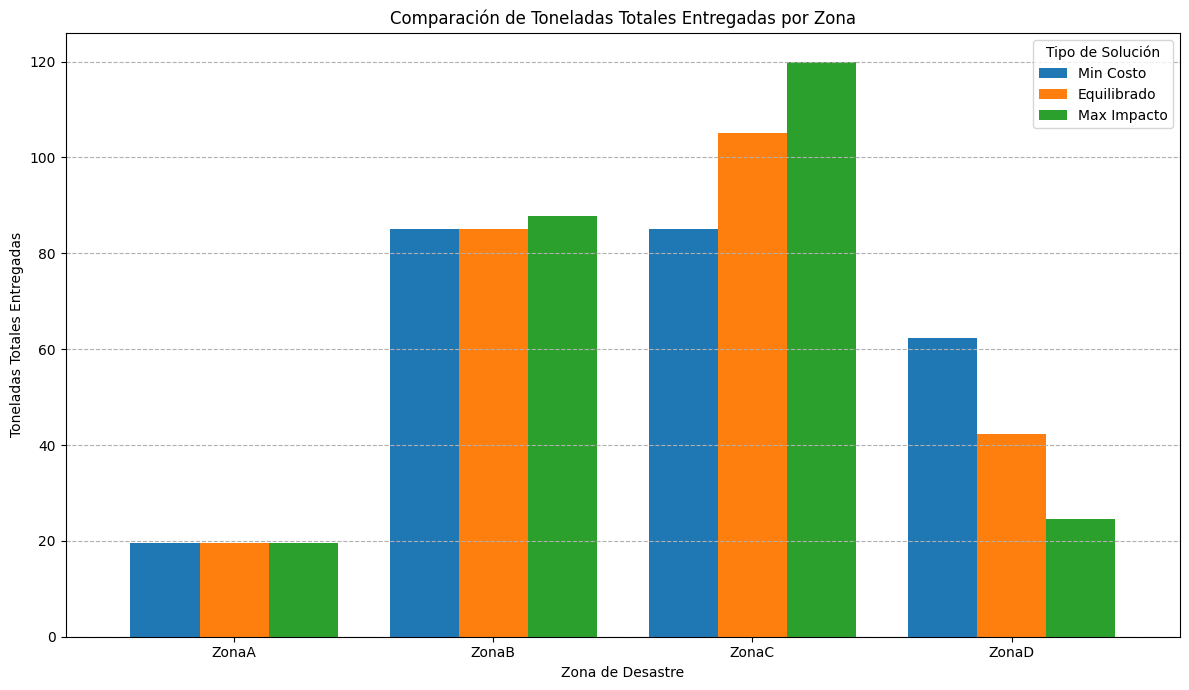

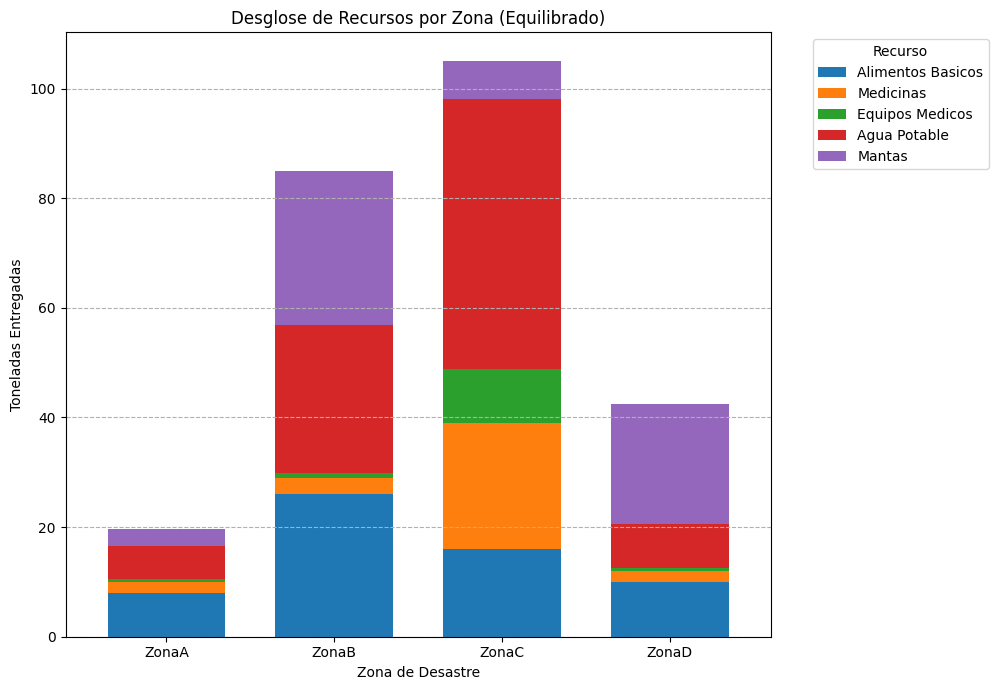

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if 'solution_details' not in locals() or not isinstance(solution_details, dict) or not solution_details:
    print("ERROR: El diccionario 'solution_details' con los valores de las variables no está definido o está vacío.")
    print("Asegúrate de modificar y ejecutar la celda del bucle e-constraint para guardarlos.")
    print("Generando gráficos con datos de ejemplo...") 


if 'idx_EM' not in locals(): idx_EM = 'Equipos Medicos'
if 'PEM' not in locals(): PEM = 0.3 
if 'recursos_set_vis' not in locals(): recursos_set_vis = ['Alimentos Basicos', 'Medicinas', 'Equipos Medicos', 'Agua Potable', 'Mantas']
if 'zonas_set_vis' not in locals(): zonas_set_vis = ['ZonaA', 'ZonaB', 'ZonaC', 'ZonaD']

def get_tons_per_zone(solution_vars, resources_all, zones_all, pem_val):
    data = []
    c_vals = solution_vars.get('C', {})
    u_vals = solution_vars.get('U', {})
    for k in zones_all:
        tons_per_resource = {res: 0.0 for res in resources_all}
        for key, tons in c_vals.items():
            try:
                i, f, zone, v = key
                if zone == k and i != idx_EM and i in tons_per_resource:
                    tons_per_resource[i] += tons
            except (ValueError, IndexError, TypeError):
                 pass 
        for key, units in u_vals.items():
            try:
                f, zone, v = key
                if zone == k and idx_EM in tons_per_resource:
                    tons_per_resource[idx_EM] += units * pem_val
            except (ValueError, IndexError, TypeError):
                 pass 
        for res, tons_val in tons_per_resource.items():
             data.append({'Zona': k, 'Recurso': res, 'Toneladas': tons_val})
    return pd.DataFrame(data)
epsilons_guardados = sorted(list(solution_details.keys()))

if len(epsilons_guardados) >= 1:
    epsilon_min_cost = epsilons_guardados[0]
    epsilon_max_impact = epsilons_guardados[-1]
    if len(epsilons_guardados) >= 3: 
        epsilon_balanced = epsilons_guardados[len(epsilons_guardados) // 2]
    else:
        epsilon_balanced = epsilon_min_cost

    solution_labels = {}
    solution_labels[epsilon_min_cost] = 'Min Costo'
    solution_labels[epsilon_max_impact] = 'Max Impacto'
    if epsilon_balanced not in [epsilon_min_cost, epsilon_max_impact]:
        solution_labels[epsilon_balanced] = 'Equilibrado'
    elif len(epsilons_guardados) == 1: 
        solution_labels[epsilon_min_cost] = 'Único Punto'
        epsilon_balanced = epsilon_min_cost 
    else: 
         if epsilon_balanced == epsilon_min_cost : solution_labels[epsilon_min_cost] += '/Equilibrado'
         if epsilon_balanced == epsilon_max_impact : solution_labels[epsilon_max_impact] += '/Equilibrado'


    print(f"Puntos seleccionados para Gráfico 1:")
    print(f"- Min Costo: Epsilon {epsilon_min_cost:.2f}")
    if epsilon_balanced in solution_labels and epsilon_balanced not in [epsilon_min_cost, epsilon_max_impact]:
         print(f"- Equilibrado: Epsilon {epsilon_balanced:.2f}")
    print(f"- Max Impacto: Epsilon {epsilon_max_impact:.2f}")

    tons_data_all = []
    valid_labels_for_plot1 = []
    epsilons_a_graficar = list(solution_labels.keys())

    for epsilon in epsilons_a_graficar:
        if epsilon in solution_details: 
            label = solution_labels[epsilon]
            df_tons_zone_res = get_tons_per_zone(solution_details[epsilon], recursos_set_vis, zonas_set_vis, PEM)
            df_total_tons_zone = df_tons_zone_res.groupby('Zona')['Toneladas'].sum().reset_index()
            df_total_tons_zone['Solucion'] = label
            tons_data_all.append(df_total_tons_zone)
            valid_labels_for_plot1.append(label)
        else:
             print(f"Advertencia: Epsilon {epsilon} tiene etiqueta pero no datos en solution_details.")

    if tons_data_all:
        df_plot1_data = pd.concat(tons_data_all)
        plt.figure(figsize=(12, 7))
        try:
            pivot_plot1 = df_plot1_data.pivot(index='Zona', columns='Solucion', values='Toneladas')
            order = [label for label in ['Min Costo', 'Equilibrado', 'Max Impacto', 'Único Punto', 'Min Costo/Equilibrado', 'Max Impacto/Equilibrado'] if label in valid_labels_for_plot1]
            if order:
                pivot_plot1 = pivot_plot1.reindex(columns=order, fill_value=0)
                pivot_plot1.plot(kind='bar', width=0.8, ax=plt.gca())
                plt.title('Comparación de Toneladas Totales Entregadas por Zona')
                plt.xlabel('Zona de Desastre')
                plt.ylabel('Toneladas Totales Entregadas')
                plt.xticks(rotation=0)
                plt.legend(title='Tipo de Solución')
                plt.grid(axis='y', linestyle='--')
                plt.tight_layout()
            else:
                print("No hay datos válidos para graficar en Gráfico 1 después de pivotar.")
        except Exception as e:
             print(f"Error al intentar crear Gráfico 1: {e}")

    else:
        print("No se procesaron datos para el Gráfico 1.")

else:
    print("El diccionario 'solution_details' está vacío. No se pueden generar gráficos.")

if 'epsilon_balanced' in locals() and epsilon_balanced is not None and epsilon_balanced in solution_details:
    print(f"\nGenerando Gráfico 2 para la solución equilibrada (Epsilon ≈ {epsilon_balanced:.2f})...")
    try:
        df_tons_balanced = get_tons_per_zone(solution_details[epsilon_balanced], recursos_set_vis, zonas_set_vis, PEM)
        pivot_plot2 = df_tons_balanced.pivot(index='Zona', columns='Recurso', values='Toneladas')
        pivot_plot2 = pivot_plot2.reindex(columns=recursos_set_vis, fill_value=0)
        pivot_plot2 = pivot_plot2.loc[:, (pivot_plot2.abs() > 1e-6).any(axis=0)]

        if not pivot_plot2.empty:
             plt.figure(figsize=(12, 7))
             pivot_plot2.plot(kind='bar', stacked=True, width=0.7, ax=plt.gca())
             balanced_label = solution_labels.get(epsilon_balanced, f"Epsilon ≈ {epsilon_balanced:.2f}")
             plt.title(f'Desglose de Recursos por Zona ({balanced_label})')
             plt.xlabel('Zona de Desastre')
             plt.ylabel('Toneladas Entregadas')
             plt.xticks(rotation=0)
             plt.legend(title='Recurso', bbox_to_anchor=(1.05, 1), loc='upper left')
             plt.grid(axis='y', linestyle='--')
             plt.tight_layout(rect=[0, 0, 0.85, 1])
        else:
             print(f"No se enviaron recursos (o valores muy bajos) en la solución con epsilon={epsilon_balanced:.2f} para mostrar en Gráfico 2.")

    except Exception as e:
        print(f"Error generando Gráfico 2: {e}")

elif 'epsilon_balanced' in locals() and epsilon_balanced is not None:
     print(f"Advertencia: No se encontraron detalles para la solución equilibrada (epsilon={epsilon_balanced}) en 'solution_details'. No se genera Gráfico 2.")
else:
     print("No se pudo determinar una solución equilibrada para el Gráfico 2.")
plt.show()

# Problema 2

## Formulación del modelo multiobjetivo

### Conjuntos

Se define el conjunto de localidades $N$ que se tienen que inspeccionar y evaluar. Además, el conjunto $E$ con todas las rutas posibles entre las localidades que se deben inspeccionar.

### Parámetros

La matriz $d_{ij}$ tiene la distancia del lugar $i\in N$ al lugar $j \in N \,|\, i \neq j$, ya que no existen autociclos. Cada ruta tiene un riesgo asociado $r_{ij}$ y cada $i \in N$ localidad tiene una calidad de inspección $n_i$. También se define un nodo $o \in N$ que será el punto de partida para que el equipo haga la inspección. 

### Variables de decisión

La variable de decisión es $X_{ij}$ que indica si el camino desde la localidad $i$ a $j$ se selecciona. El dominio de la variable de decisión es binaria ($X_{ij} \in \{0, 1\}$), 1 si se selecciona y 0 de lo contrario. Además, es necesario incluir una variable auxiliar $u_i$ para cada $i \in N \backslash \{o\}$ para darle un orden a las localidades recorridas, por ejemplo, si se toma el camino $(i,j) \in E$ el valor de $u_j > u_i$. Asimismo, los valores que puede tomar $u_i$ son, ya que se sabe que el nodo origen es 0, de $1$ hasta $|N|$. 

### Funciones objetivo

Bien se sabe que se quieren optimizar tres aspectos de este problema. Se tiene que minimizar distancia recorrida. 
$$
Z_1 = \min \sum_{(i,j) \in E} X_{ij} \times d_{ij}
$$
Además, se debe máximizar la calidad de inspección de la ruta. 
$$
Z_2 = \max \sum_{(i,j) \in E} X_{ij} \times n_i \times d_{ij}
$$
También se debe minimizar el riesgo de las rutas elegidas. 
$$
Z_3 = \min \sum_{(i,j) \in E} X_{ij} \times r_{ij}
$$

Recordemos que para poder realizar la optimización todas las funciones deben o maximizar o minimizar. Por esto, es necesario cambiar el objetivo de $Z_2$, en este caso $Z_2^*=\min-Z_2$.
$$
Z_2^* = \min \left(-\sum_{(i,j) \in E} X_{ij} \times n_i \times d_{ij} \right)
$$

### Restricciones

Se sabe que el equipo debe salir del nodo origen.
$$
\sum_{j \in N} X_{ij} = 1, \forall i \in N \, | \, i = o
$$
El equipo de inspección debe volver al nodo de origen. 
$$
\sum_{i \in N} X_{ij} = 1, \forall j \in N \, | \, j = o
$$
El equipo debe entrar a cada una de las localidades. 
$$
\sum_{i \in N \, | \, i \neq j} X_{ij} = 1, \forall j \in N \backslash \{o\}
$$
El equipo debe salir de cada una de las localidades. 
$$
\sum_{j \in N \, | \, j \neq i} X_{ij} = 1, \forall i \in N \backslash \{o\}
$$
Adicionalmente, se debe agregar la restricción MTZ para la eliminación de subtoures.
$$
u_i - u_j + (|N| - 1) X_{ij} \leq |N| - 2, \forall i, j \in N \, | \, 1 \leq i \wedge j \leq |N| \wedge i \neq j
$$

## Selección y justificación del método de resolución

## Implementación y análisis

## Análisis y discusión adicional